Lau Jun Kit Darrick, dl5215, 01112514

TODO: 1.1.2 What is stationarity?
TODO: 1.1.3 Signal gaussianity?

# 1. Regression Methods
## 1.1 Processing Stock Price Data in Python
### 1.1.1 Time-series Plot

Let's start with a basic sanity check by visualising the types of the dataset.

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
%matplotlib inline

data = pd.read_csv("data/priceData.csv")
print(data.dtypes)
data.isnull().sum()

date          object
SPX Index    float64
dtype: object


date           0
SPX Index    655
dtype: int64

We see that there are actually 655 null values present in the `SPX Index` column, where we expect a `float64`. Additionally, the `Date` column is not required, so let's get rid of it. The data is not perfectly sequential, so we'll get rid of the entries with `dropna()`.

<AxesSubplot:title={'center':'Logarithmic SPX Price'}>

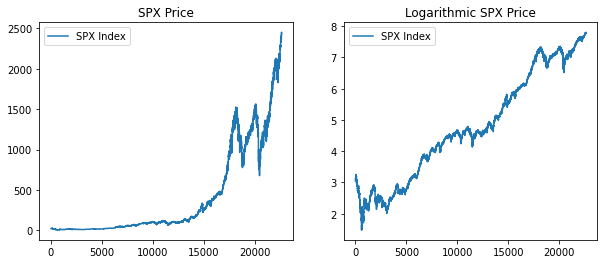

In [3]:
px = data.drop(['date'], axis=1)
px = px.dropna()
logpx = np.log(px)

figure, axes = plt.subplots(1,2)
figure.set_size_inches(10,4)

px.plot(title="SPX Price", ax=axes[0])
logpx.plot(title="Logarithmic SPX Price", ax=axes[1])

We see immediately that there is an upward trend in both graphs, and that applying the natural logarithm suppresses the range of the output, while still preserving order. To draw further observations on the stationarity (or lack thereof) of this time series, let's plot some additional statistics.

### 1.1.2 Sliding Mean & Variance

TODO: Definition and motivation of stationarity 

Taking a sliding window of 252 samples, it can be observed that there is an upward trend in the mean with no easily discernable seasonal pattern. Spikes in variance correspond to corrections or market crashes, where large relative daily changes in price are observed. While the standard deviation is relatively stable, oscillating within 0.3, the upward movement in the mean breaks our definition of stationarity, and will require additional mathematical manupulation to remove, which we will explore in upcoming sections.

<AxesSubplot:title={'center':'252-day Sliding Standard Deviation'}>

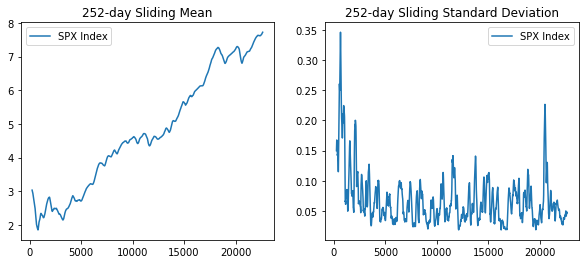

In [4]:
figure, axes = plt.subplots(nrows=1, ncols=2)

# Sliding Mean & S.D.
figure.set_size_inches(10,4)
logpx.rolling(252).mean().plot(ax=axes[0], title="252-day Sliding Mean")
logpx.rolling(252).std().plot(ax=axes[1], title="252-day Sliding Standard Deviation")

### 1.1.3 Simple & Log-return Time Series

Comparing the two plots, we see the property of the natural logarithm where $ Log(1+r) \approx Log(1) + Log(r) $ for small $r$. In fact, the two graphs are almost indistinguishable as daily percentage changes in the S&P500 are usually within this approximation tolerance, except for a few outlying points. 

First-order differencing has successfully de-trended the moving average, and the standard deviation has been reduced by a factor of 10. This time-series is much more stationary as the mean oscillates in very small amplitudes around 0, implying a mean-reverting nature of this time-series. Furthermore, the data in both cases exhibit gaussian properties which further motivate the application of signal processing techniques.

<AxesSubplot:title={'center':'252-day Sliding Window S.D. of Simple returns'}>

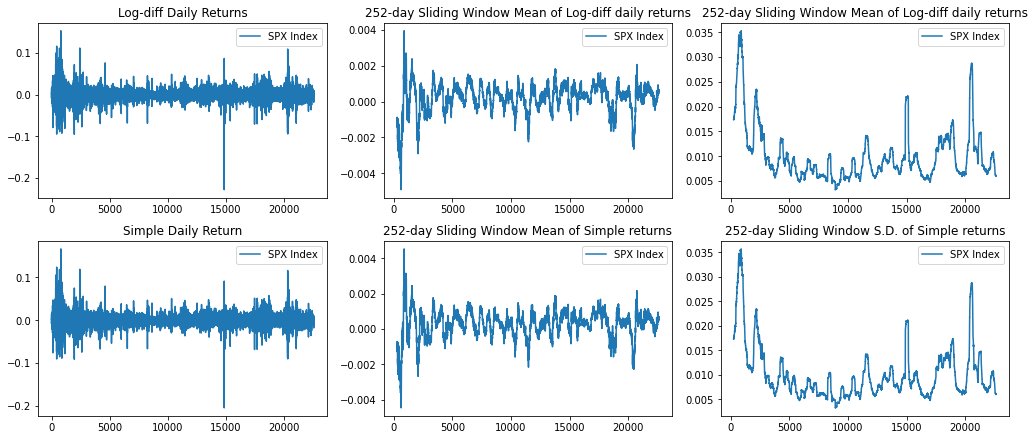

In [5]:
figure.clf()
figure, axes = plt.subplots(nrows=2, ncols=3, constrained_layout=True)
figure.set_size_inches(14,6)

logret = logpx.diff()
logret.plot(title="Log-diff Daily Returns", ax=axes[0,0])
logret.rolling(252).mean().plot(title="252-day Sliding Window Mean of Log-diff daily returns", ax=axes[0,1])
logret.rolling(252).std().plot(title="252-day Sliding Window Mean of Log-diff daily returns", ax=axes[0,2])

simpret = px.pct_change()
simpret.plot(title="Simple Daily Return", ax=axes[1,0])
simpret.rolling(252).mean().plot(title="252-day Sliding Window Mean of Simple returns", ax=axes[1,1])
simpret.rolling(252).std().plot(title="252-day Sliding Window S.D. of Simple returns", ax=axes[1,2])

### 1.1.4 Theoretically justify the suitability of log returns over simple returns for signal processing purposes. Next, perform the “Jarque-Bera” test for Gaussianity on the data, and comment on the results in light of your theoretical answer.



In [6]:
from scipy import stats
# return the Jarque−Bera test p−value for a time−series x 
pd.DataFrame(data=np.array([[stats.jarque_bera(px)[1], stats.jarque_bera(logpx)[1], stats.jarque_bera(logret.dropna())[1], stats.jarque_bera(simpret.dropna())[1]]]), columns=["Price", "Log-price", "Log-diff", "Simple % Change"])

,Price,Log-price,Log-diff,Simple % Change
0,0.0,0.0,0.0,0.0


### 1.1.5 You purchase a stock for £1. The next day its value goes up to £2 and the following day back to £1. What are the simple and logarithmic returns over this period and what can you conclude about logarithmic returns on the basis of this example?

We see from the simple script that the price movement that the movement of the log-price matches that of the original price. An increase of $1 (100%) followed by a decrease of the same amount (50%) results in 2 equal and opposite movements of 0.693 in the logarithm. However, the percentage price is different in both cases. Logarithmic returns thus allow us to track and analyse a series of gains and losses in a more symmetric and predictable way than simple returns.

In [27]:
simple_stock_price = pd.DataFrame(data=[1,2,1], columns=["Price"])
simple_stock_price['Simple Return'] = simple_stock_price.pct_change()
simple_stock_price['Log-price Diff'] = np.log(simple_stock_price['Price']).diff()
simple_stock_price

,Price,Simple Return,Log-price Diff
0,1,NaN,NaN
1,2,1.0,0.693147
2,1,-0.5,-0.693147


### 1.1.6 Under what circumstances should you not use log returns over simple returns?

Most models in quantitative finance argue that prices in the short-term are log-normally distributed. Taking log-returns for long-term analysis breaches this assumption and the resulting time series may not be ideal. 

Let us consider the problem of portfolio optimisation using the Markowitz model. We aim to find an optimal weighting vector $w$ across assets to maximise returns while minimising risk (variance). 

Using simple returns, we can easily determine the simple return in our portfolio over time given by the vectorial equation $r_p = w^Tr$. Because of this, we say that simple returns are additive across assets, as we can take the simple returns across all our assets (the vector $r$), scale them by our allocation weights $w$ and determine a simple return for our whole portfolio.

Log-returns cannot be used for this purpose since the weighted average of the log returns across assets does not equal the return of the portfolio.

## 1.2 ARMA vs. ARIMA Models for Financial Applications

### 1.2.1 Plot the S&P500 time-series. Following the process in Question 1.1.1, comment on whether an ARMA or ARIMA model would be more appropriate. (TODO)

Let's do our usual sanity check of visualising the data and checking for nulls.


In [28]:
import pandas as pd
import matplotlib . pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.ar_model import AR 
import copy

snp = pd.read_csv("data/snp_500_2015_2019.csv")
snp.set_index(["Date"], inplace=True)
print(snp.head(5))
print(snp.isna().sum())


                   High          Low         Open        Close      Volume  \
Date                                                                         
2015-01-02  2072.360107  2046.040039  2058.899902  2058.199951  2708700000   
2015-01-05  2054.439941  2017.339966  2054.439941  2020.579956  3799120000   
2015-01-06  2030.250000  1992.439941  2022.150024  2002.609985  4460110000   
2015-01-07  2029.609985  2005.550049  2005.550049  2025.900024  3805480000   
2015-01-08  2064.080078  2030.609985  2030.609985  2062.139893  3934010000   

              Adj Close  
Date                     
2015-01-02  2058.199951  
2015-01-05  2020.579956  
2015-01-06  2002.609985  
2015-01-07  2025.900024  
2015-01-08  2062.139893  
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


<AxesSubplot:xlabel='Date'>

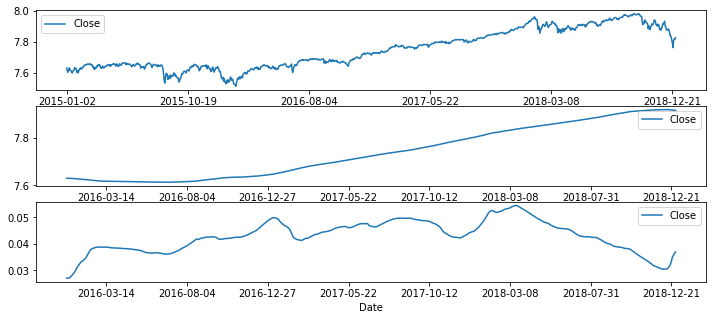

In [20]:
snp_close_log = snp["Close"].to_frame().apply(np.log)

figure, axes = plt.subplots(nrows=3, ncols=1)
figure.set_size_inches(12,5)

snp_close_log.plot(ax=axes[0])
snp_close_log.rolling(252).mean().plot(ax=axes[1])
snp_close_log.rolling(252).std().plot(ax=axes[2])

We see from the data that this time series is clearly not stationary due to the upward trend that we observed in the previous section, and so an ARIMA method would be more appropriate so that we may skip the hassle of finding an appropriate de-trending solution. We will see that an ARMA model will not be ideal since we are applying it to non-stationary data, which is otherwise a requirement of ARMA models.

### 1.2.2 Fit an ARMA(1, 0) model using the commands below. Plot, in the same figure, both the prediction and the true signal. Inspect the model parameters (model.params). Comment on the results. Are these findings useful in practice? (TODO)

The model initially looks to be fitting the data very well, but closer inspection on the last 50 values in the series shows that the predicted version actually lags the true signal. 



/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


,0
const,7.748867
ar.L1,0.997354
sigma2,0.000074


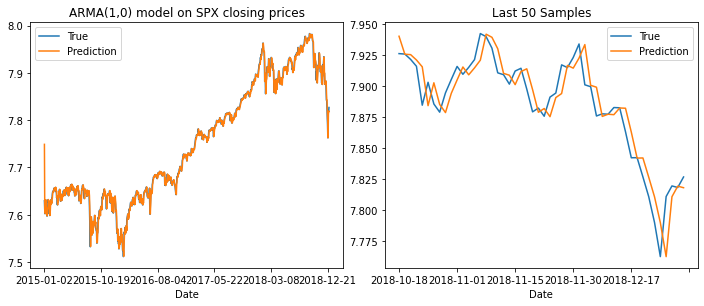

In [38]:
snp_arma = copy.deepcopy(snp_close_log)
snp_arma.columns = ["True"]
model = ARIMA(snp_arma, order=(1,0,0)).fit()
snp_arma["Res"] = model.resid
snp_arma["Prediction"] = snp_arma["True"] - snp_arma["Res"]

figure, axes = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(10,4)
figure.tight_layout()

axes[0].set_title("ARMA(1,0) model on SPX closing prices")
snp_arma.drop(["Res"], axis=1).plot(ax=axes[0])

axes[1].set_title("Last 50 Samples")
snp_arma.drop(["Res"], axis=1).iloc[-50:].plot(ax=axes[1])

model.params.to_frame()

### 1.2.3 Repeat Question 1.2.2, this time by fitting an ARIMA(1, 1, 0) model. Comment on the results. Compare your results with those in Question 1.2.2. Which analysis is more physically meaningful? (TODO)

/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<AxesSubplot:xlabel='Date'>

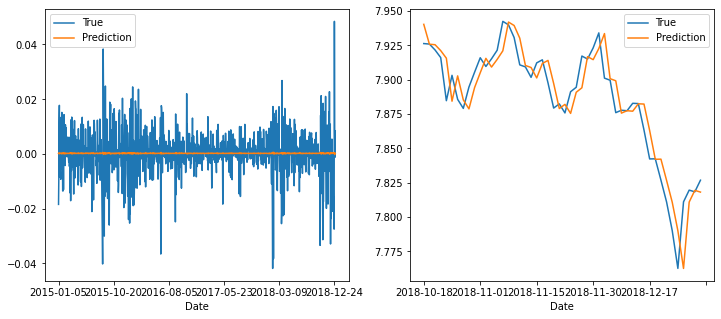

In [40]:
snp_close_logdiff = snp_close_log.diff()
snp_arima = copy.deepcopy(snp_close_logdiff.dropna())
snp_arima.columns = ["True"]
snp_arima["Res"] = ARIMA(snp_arima, order=(1,1,0)).fit().resid
snp_arima["Prediction"] = snp_arima["True"] - snp_arima["Res"]

figure, axes = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(12,5)
snp_arima.drop(["Res"], axis=1).plot(ax=axes[0])
snp_arma.drop(["Res"], axis=1).iloc[-50:].plot(ax=axes[1])
# snp_arima["Res"].plot(ax=axes[1])

### 1.2.4 Comment on the necessity of taking the log of the prices for the ARIMA analysis. (TODO)

Applying an element-wise logarithm allows us to analyse percentage changes instead of unit changes. For stock market prices, this is the behaviour we desire, as prices tend to have an upward trend on average. 

/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<AxesSubplot:xlabel='Date'>

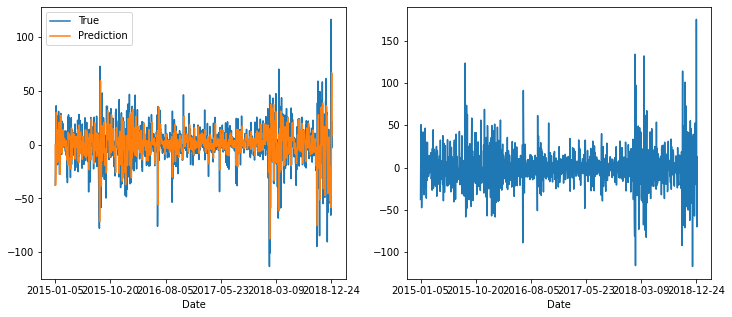

In [24]:
snp_diff = snp["Close"].to_frame().diff()
snp_arima = copy.deepcopy(snp_diff.dropna())
snp_arima.columns = ["True"]
snp_arima["Res"] = ARIMA(snp_arima, order=(1,1,0)).fit().resid
snp_arima["Prediction"] = snp_arima["True"] - snp_arima["Res"]

figure, axes = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(12,5)
snp_arima.drop(["Res"], axis=1).plot(ax=axes[0])
snp_arima["Res"].plot(ax=axes[1])

# 2. Bond Pricing

## 2.1 Examples of Bond Pricing

### 2.1.1 An investor receives USD 1,100 in one year in return for an investment of USD 1,000 now. Calculate the percentage return per annum with: a) Annual compounding, b) Semiannual compounding, c) Monthly compounding, d) Continuous compounding

We wish to calculate the effective interest rate in all cases.

* Under annual compounding, his annual return is $10\%$.
* Under semi-annual compounding, the effective rate is $(1 + \frac{0.10}{2})^2 - 1 = 10.25\%$
* Under monthly compounding, the effective rate is $(1 + \frac{0.10}{12})^{12} - 1 = 10.47\%$
* Under continuous compounding, the effective rate is $e^{0.1} - 1 = 10.52\%$

### 2.1.2 What rate of interest with continuous compounding is equivalent to 15% per annum with monthly compounding?

We simply solve for two equal effective rates: 
$$ 
(1 + \frac{0.15}{12})^{12} - 1 = e^r\\

1.1608 = e^r \\

r = ln (0.2608) = 14.9\%
$$

### 2.1.3 A deposit account pays 12% per annum with continuous compounding, but interest is actually paid quarterly. How much interest will be paid each quarter on a USD 10,000 deposit?

The payment is simply calculated with $ payment = \$10000 * (e^{0.12 * 0.25} -1) = \$304.55$

## 2.2 Forward rates

Suppose that the one–year interest rate, $r_1$ is 5%, and the two–year interest rate, $r_2$ is 7%. 

If you invest USD 100 for one year, your investment grows to $100 × 1.05 = USD 105$.

If you invest for two years, it grows to $100×1.07^2 = USD 114.49$. 

The extra return that you earn for that second year is $1.07^2/1.05−1 = 0.090 = 9.0 \%$.
(Hint: The extra return for lending for one more year is termed the forward rate of interest).

### 2.2.1 Would you be happy to earn that extra 9% for investing for two years rather than one?
By construction, the forward rate implies a no-arbitrage scenario. Therefore, there is no difference in profit whether I invest for one year or two. 

### 2.2.2 Comment on the 5%, 7%, and 9% investment strategies.
No strategy is any more optimal than another at this point, since all rates are based on present interest rates in a no-arbitrage environment. However, the difference between the three choices arises through interest rate fluctuation.

A shorter commitment might therefore be better as the 2-year commitment may be suboptimal if a better opportunity were to arise in the time. Conversely, if interest rates were to fall within the first year, locking in this 2-year commitment may be an ideal decision.

### 2.2.3 Comment on the advantages and disadvantages of the forward rate of 9%.
The forward rate is calculated based on the current interest rates and is thus subject to interest rate fluctuation. It still carries the same commitment as the %7\%$ two-year rate, since we would have to commit to investing the returns of a 1-year investment for a year, a year from now to obtain it.

However, it does at least give us an idea of how our borrower perceived interest rate movement. A forward rate of 9% implies that the 1-year interest rate is 9%, almost double of this year's 5% interest rate.

### 2.2.4 How much would you need to go from 1y investment to 2y investment and what does it depend upon?
Provided the interest rate does not change, no money is needed to translate between the two investments.

## 2.3 Duration of a Coupon-bearing Bond

### 2.3.1 Calculate the Duration of the 1% 7-year bond in the table.
The terms of the duration have been calculated for us in the last row of the table, and so the answer is attained with a simple summation:

$ 0.0124 + 0.0236 + 0.0337 + 0.0428 + 0.0510 + 0.0583 + 6.5377 = 6.7595 $ years

### 2.3.2 Calculate the modified duration of the bond.

Since the annual yield to maturity is 5%, under annual compounding, the modified duration is obtained by

$ D_m = \frac{D}{1 + {0.05}} = \frac{6.7595}{1.05} = 6.438 $ years

The modified duration is lower than the duration, since we obtain it by discounting the latter by its yield to maturity.

### 2.3.3 

In [103]:
6.7595 / 1.05

6.437619047619047